In [1]:
#figdir = '/home/kpmurphy/github/rebayes/demos/figures' # TPU
figdir = '/Users/kpmurphy/github/rebayes/demos/figures' # laptop

In [2]:
# Gerardo's
figdir = "./showdown/output/images/"

In [3]:
%load_ext autoreload
%autoreload 2

In [3]:
import re
import jax
import optax
import distrax
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp

from time import time
from copy import deepcopy
from jax.flatten_util import ravel_pytree
from flax.training.train_state import TrainState
from functools import partial
from typing import Callable, Tuple, Any
from tqdm.notebook import tqdm
from itertools import product

import rebayes
from rebayes import base
from rebayes.base import Rebayes
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter import lofi, lrvga
from rebayes.sgd_filter import sgd
from rebayes.sgd_filter import replay_sgd as rsgd

In [4]:
plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 14
# plt.rcParams["lines.linewidth"] = 2

In [5]:
%config InlineBackend.figure_format = "retina"

# Data

In [6]:
def make_1d_regression(
    key, n_train=100, n_test=100, sort_data=False, coef0=2.0, coef1=3.0, coef2=1.0
):  
    key_train, key_test = jax.random.split(key)
    keys_train = jax.random.split(key_train, n_train)
    keys_test = jax.random.split(key_test, n_test)
    minval, maxval = -0.5, 0.5
        
    @jax.vmap
    def gen(key):
        key_x, key_y = jax.random.split(key)
        x = jax.random.uniform(key_x, shape=(1,), minval=minval, maxval=maxval)
        
        noise = jax.random.normal(key) * 0.02
        y = coef2 * x + 0.3 * jnp.sin(coef0 + coef1 * jnp.pi * x)
        y = y + noise        
        return x, y
    
    X_train, y_train = gen(keys_train)
    X_test, y_test = gen(keys_test)
    
    # Standardize dataset
    if True:
        X_train = (X_train - X_train.mean()) / X_train.std()
        y_train = (y_train - y_train.mean()) / y_train.std()
        X_test = (X_test - X_test.mean()) / X_test.std()
        y_test = (y_test - y_test.mean()) / y_test.std()

    train = (X_train, y_train)
    test = (X_test, y_test)
    return train, test


def make_coefs(key, n_dist):
    """
    Make c0, c1 distributions
    """
    coefs = jax.random.uniform(key, shape=(n_dist, 2), minval=-5, maxval=5)
    return coefs


def sample_1d_regression_sequence(key, n_dist, n_train=100, n_test=100):
    key_coef, key_dataset = jax.random.split(key)
    keys_dataset = jax.random.split(key_dataset, n_dist)
    coefs = make_coefs(key, n_dist)
    
    @jax.vmap
    def vsample_dataset(key, coefs):
        train, test = make_1d_regression(
            key, n_train, n_test, coef0=coefs[0], coef1=coefs[1]
        )
        return train, test
    
    collection = vsample_dataset(keys_dataset, coefs)
    collection_flat = jax.tree_map(lambda x: x.reshape(-1, 1), collection)
    collection_train, collection_test = collection_flat
    
    train_id_seq = jnp.repeat(jnp.arange(n_dist), n_train)
    test_id_seq = jnp.repeat(jnp.arange(n_dist), n_test)
    
    collection_flat = {
        "train": {
            "X": collection_train[0],
            "y": collection_train[1],
            "id_seq": train_id_seq
        },
        "test": {
            "X": collection_test[0],
            "y": collection_test[1],
            "id_seq": test_id_seq
        }
    }
    
    collection_train, collection_test = collection
    collection_task = {
        "train": {
            "X": collection_train[0],
            "y": collection_train[1]
        },
        "test": {
            "X": collection_test[0],
            "y": collection_test[1],
        }
    }
    
    return collection_flat, collection_task


def slice_tasks(datasets, task):
    datasets = deepcopy(datasets)
    train_seq = datasets["train"].pop("id_seq") == task
    test_seq = datasets["test"].pop("id_seq") == task
    
    train = datasets["train"]
    test = datasets["test"]
    
    train = jax.tree_map(lambda x: x[train_seq], train)
    test = jax.tree_map(lambda x: x[test_seq], test)
    
    datasets = {
        "train": train,
        "test": test
    }
    
    return datasets

In [7]:
key = jax.random.PRNGKey(314)
n_dist = 6
n_train = 100
data_flat, data_tasks = sample_1d_regression_sequence(key, n_dist, n_train=n_train)
jax.tree_map(jnp.shape, data_flat)

{'test': {'X': (600, 1), 'id_seq': (600,), 'y': (600, 1)},
 'train': {'X': (600, 1), 'id_seq': (600,), 'y': (600, 1)}}

In [8]:
jax.tree_map(jnp.shape, data_tasks)

{'test': {'X': (6, 100, 1), 'y': (6, 100, 1)},
 'train': {'X': (6, 100, 1), 'y': (6, 100, 1)}}

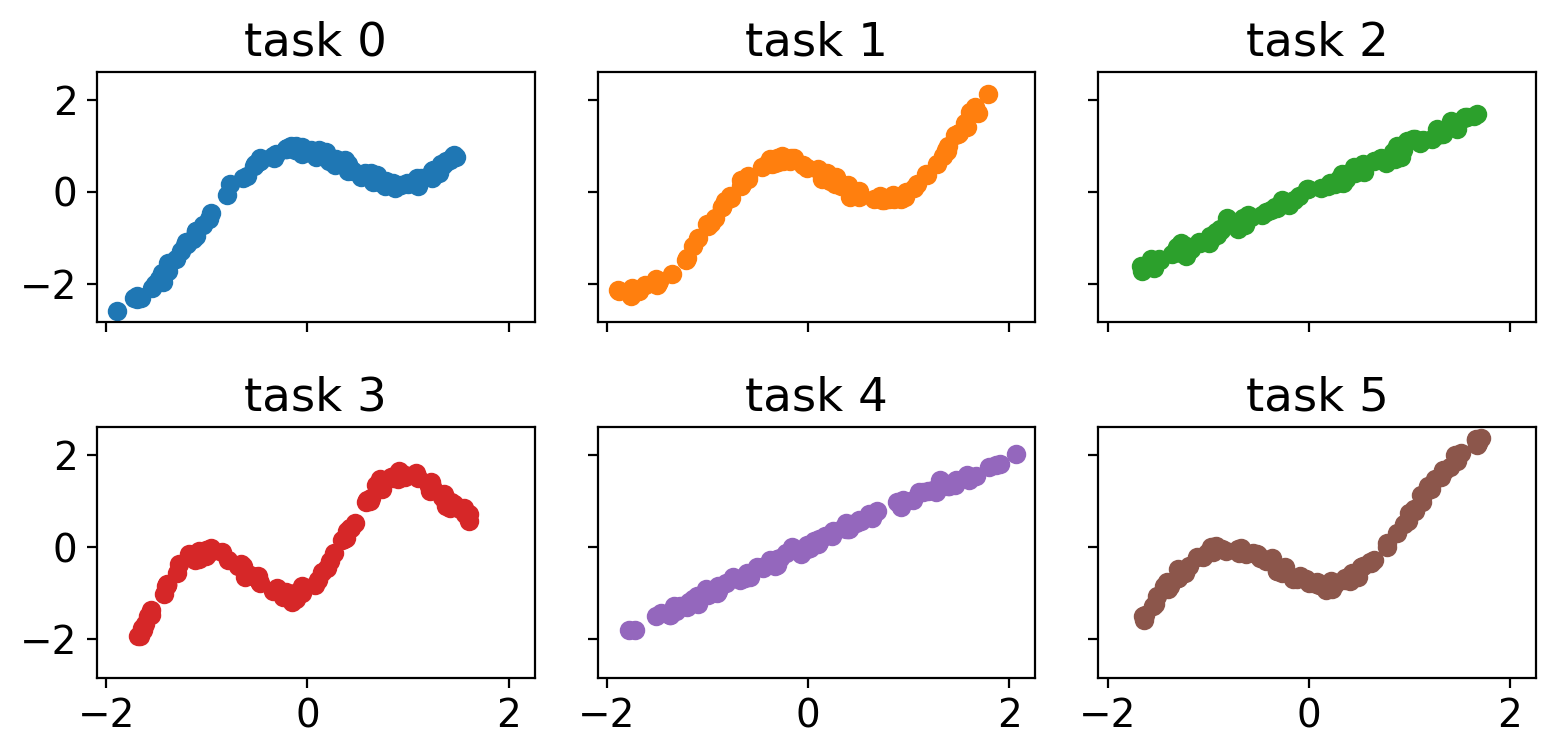

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(8, 4), sharex=True, sharey=True)

colors = plt.cm.tab10(np.arange(n_dist))
for n, ax in enumerate(axs.ravel()):
    data_slice = slice_tasks(data_flat, n)
    c=colors[n]
    ax.scatter(data_slice["train"]["X"], data_slice["train"]["y"], color=c)
    ax.set_title(f"task {n}")
plt.tight_layout()

## Modeling

In [10]:
class MLP(nn.Module):
    n_out: int
    n_hidden: int
    activation: Callable = nn.elu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x
    
def make_bnn_flax(nhidden=50):
    key = jax.random.PRNGKey(314)
    dim_out = 1
    dim_in = 1 
    model = MLP(dim_out, nhidden)
    params = model.init(key, jnp.ones((1, dim_in)))
    flat_params, recfn = ravel_pytree(params)
    n_params = len(flat_params)
    return model, params, flat_params, recfn

In [11]:
model, dnn_params, flat_params, recfn = make_bnn_flax()

In [983]:
def apply_fn_flat(flat_params, x):
    return model.apply(recfn(flat_params), x)

def apply_fn_unflat(params, x):
    return model.apply(params, x)

ssm_params = base.RebayesParams(
        initial_mean=flat_params,
        # initial_covariance=0.01, # try 1.0, 10.
        initial_covariance=5.0,
        dynamics_weights=1,
        dynamics_covariance=0.01,
        emission_mean_function=apply_fn_flat,
        emission_cov_function = lambda w,x: 0.1,
        adaptive_emission_cov=False,
        dynamics_covariance_inflation_factor=.001,
    )



@partial(jax.jit, static_argnames=("apply_fn",))
def lossfn_rmse_fifo(params, counter, X, y, apply_fn):
    yhat = apply_fn(params, X).ravel()
    y = y.ravel()
    err = jnp.power(y - yhat, 2)
    loss = (err * counter).sum() / counter.sum()
    return loss


In [984]:
X_train_seq = data_flat["train"]["X"]
Y_train_seq = data_flat["train"]["y"]
train_id_seq = data_flat["train"]["id_seq"]

X_test_seq = data_flat["test"]["X"]
Y_test_seq = data_flat["test"]["y"]
test_id_set = data_flat["test"]["id_seq"]


X_test_tasks = data_tasks["train"]["X"]
Y_test_tasks = data_tasks["train"]["y"]
X_train_tasks = data_tasks["train"]["X"]
Y_train_tasks = data_tasks["train"]["y"]

## Rebayes

In [985]:
# callback depends on the test set - could pass as kwargs
def callback(bel, pred_obs, t, Xt, Yt, bel_pred, apply_fn, **kwargs):    
    # eval on all tasks test set
    yhat = apply_fn(bel.mean, X_test_seq).squeeze()
    ytrue = Y_test_seq.squeeze()
    rmse_test_all_tasks = jnp.mean(jnp.square(yhat - ytrue)) 

    # eval on current task 
    task = train_id_seq[t]
    yhat = apply_fn(bel.mean, X_test_tasks[task]).squeeze()
    #yhat = apply_fn_flat(bel.mean, X_test_tasks[task]).squeeze()
    ytrue = Y_test_tasks[task].squeeze()
    rmse_test_current_task = jnp.sqrt(jnp.mean(jnp.square(yhat - ytrue)))
    mae_test_current_task = jnp.mean(jnp.abs(yhat - ytrue))

    out = {'rmse_test_all_tasks': rmse_test_all_tasks,
           'rmse_test_current_task': rmse_test_current_task,
           'mae_test_current_task': mae_test_current_task,
           'pred_test_current_task': yhat,
           "bel": bel,
           }
    return out

In [1154]:
method_list, estimator_list, callback_list = [], [], []

if 1:
    memory_list = [10]
    #q_list = [0, 0.01]
    q_list = [0.01]
    alpha_list = [0.01]
    combos = product(memory_list, q_list, alpha_list)
    for (mem, q, alpha) in combos:
        method = "lofi mem {:d}, q {:0.2f}, alpha {:0.2f}".format(mem, q, alpha)
        lofi_params = lofi.LoFiParams(memory_size=mem, steady_state=False, diagonal_covariance=True)
        my_ssm_params = deepcopy(ssm_params)
        my_ssm_params = my_ssm_params.replace(dynamics_covariance_inflation_factor = alpha, dynamics_covariance = q)
        estimator = lofi.RebayesLoFi(my_ssm_params, lofi_params, method="lofi", inflation="hybrid")
        method_list.append(method)
        estimator_list.append(estimator)
        callback_list.append(partial(callback, apply_fn = apply_fn_flat))


if 1:
    lr_list = [0.1]
    buffer_list = [1, 10]
    n_inner = 1
    combos = product(lr_list, buffer_list)
    for (lr, buffer) in combos:
        method = 'sgd lr {:0.3f} B {:d} E {:d}'.format(lr, buffer, n_inner)
        estimator = rsgd.FifoSGD(lossfn_rmse_fifo, 
                            apply_fn=apply_fn_unflat,
                            init_params = dnn_params,
                            tx = optax.adam(learning_rate=lr),
                            buffer_size = buffer,
                            dim_features = X_train_seq.shape[1],
                            dim_output = 1,
                            n_inner = n_inner)

        method_list.append(method)
        estimator_list.append(estimator)
        callback_list.append(partial(callback, apply_fn = apply_fn_unflat))

if 1:
    method = 'fcekf'
    estimator = ekf.RebayesEKF(ssm_params, method=method)
    method_list.append(method)
    estimator_list.append(estimator)
    callback_list.append(partial(callback, apply_fn = apply_fn_flat))


if 1:
    method = 'vdekf'
    estimator = ekf.RebayesEKF(ssm_params, method=method)
    method_list.append(method)
    estimator_list.append(estimator)
    callback_list.append(partial(callback, apply_fn = apply_fn_flat))

    method = 'fdekf'
    estimator = ekf.RebayesEKF(ssm_params, method=method)
    method_list.append(method)
    estimator_list.append(estimator)
    callback_list.append(partial(callback, apply_fn = apply_fn_flat))

In [1155]:
# run the estmators

rmse_trace_list, elapsed_list, output_list  = [], [], []

for i, estimator in enumerate(estimator_list):
    t0 = time()
    bel, outputs = estimator.scan(X_train_seq, Y_train_seq, callback=callback_list[i])
    t1 = time()
    elapsed = t1-t0
    elapsed_list.append(elapsed)
    output_list.append(outputs)

In [1156]:
def parse_name(method):
    parts = method.split()
    name = parts[0]
    numbers = re.findall(r"[-+]?(?:\d*\.*\d+)", method)
    if False: #name=='lofi':
        mem, q, alpha = numbers[0], float(numbers[1]), float(numbers[2])
        if q > 0:
            style = ':'
        else:
            style = '-.'
        if alpha > 0:
            marker = 'o'
        else:
            marker = 'x'
    elif name == 'lofi':
        style = ':'
        marker = 'o'
    elif name == 'sgd':
        style = '--'
        marker = 'x'
    elif "lrvga" in name:
        style = "dashdot"
        marker = "v"
    else:
        style = '-'
        marker = '*'
    return style, marker

def make_plot_dict(method_list):
    nmethods = len(method_list)
    colors = plt.cm.tab10(np.arange(nmethods)+1)
    color_dict, style_dict, marker_dict = {}, {}, {}
    for i, method in enumerate(method_list):
        style, marker = parse_name(method)
        style_dict[method] = style
        marker_dict[method] = marker
        color_dict[method] = colors[i,:]
    return color_dict, style_dict, marker_dict

In [1157]:
def plot_pred(Xtr, ytr, Xte, yte, yhat, ttl, ax=None):
    if ax is None:
        fig, ax = plt.subplot()    
    ax.plot(Xtr, ytr, 'o', color="black", label='train')
    ax.plot(Xte, yte, 'x', color="red", label='test')
    ax.plot(Xte, yhat, '*', color="blue", label='pred')
    ax.set_xticklabels([])
    ax.legend()
    ax.set_title(ttl)


def plot_pred_task(task, outputs, ax, name=''):
    times = jnp.where(train_id_seq == task)
    last_time = times[0][-1]
    yhat = outputs['pred_test_current_task'][last_time,:]
    rmse = outputs['rmse_test_current_task'][last_time]
    mae = outputs['mae_test_current_task'][last_time]
    #ttl = 'method {:s}, task {:d}, time {:d}, rmse {:0.3f}'.format(name, task, last_time, rmse)
    #ttl = '{:s},  rmse {:0.3f}, mae {:0.3f}'.format(name, rmse, mae)
    ttl = '{:s}, mae={:0.3f}'.format(name,  mae)
    # ttl = f'{name:s}, {mae=:0.3f}'
    plot_pred(X_train_tasks[task], Y_train_tasks[task], X_test_tasks[task], Y_test_tasks[task], yhat, ttl, ax)

# L-RVGA

In [1158]:
def fwd_link_main(mean, bel, x, model, reconstruct_fn):
    params = reconstruct_fn(mean)
    means = model.apply(params, x).ravel()
    std = bel.sigma
    return means, std ** 2


def log_prob_main(mean, bel, x, y, fwd_link):
    yhat, var = fwd_link(mean, bel, x)
    std = jnp.sqrt(var)
    
    logp = distrax.Normal(yhat, std).log_prob(y).sum()
    return logp

In [1331]:
key = jax.random.PRNGKey(314)
dim_rank = 10

std = 1.0
eps = 1e-6
sigma2 = 1.5 # 1.1

n_samples = 50
n_outer = 5
n_inner = 6

time_init = time()
bel_init, reconstruct_fn = lrvga.init_lrvga(key, model, X_train_seq, dim_rank, std, eps, sigma2)

fwd_link = partial(fwd_link_main, model=model, reconstruct_fn=reconstruct_fn)
log_prob = partial(log_prob_main, fwd_link=fwd_link)

alpha = 0.995
agent = lrvga.LRVGA(fwd_link, log_prob, n_samples=n_samples, n_outer=n_outer, n_inner=n_inner, alpha=alpha)

eval_callback = partial(callback, apply_fn=apply_fn_flat)
bel, output = agent.scan(
    X_train_seq, Y_train_seq.ravel(), callback=eval_callback, progress_bar=True, bel=bel_init,
)

bel = jax.block_until_ready(bel)
time_end = time()

  0%|          | 0/600 [00:00<?, ?it/s]

In [1332]:
output_list.append(output)
elapsed_list.append(time_end - time_init)
method_list = method_list + ["lrvga mem 10, alpha 0.995"]

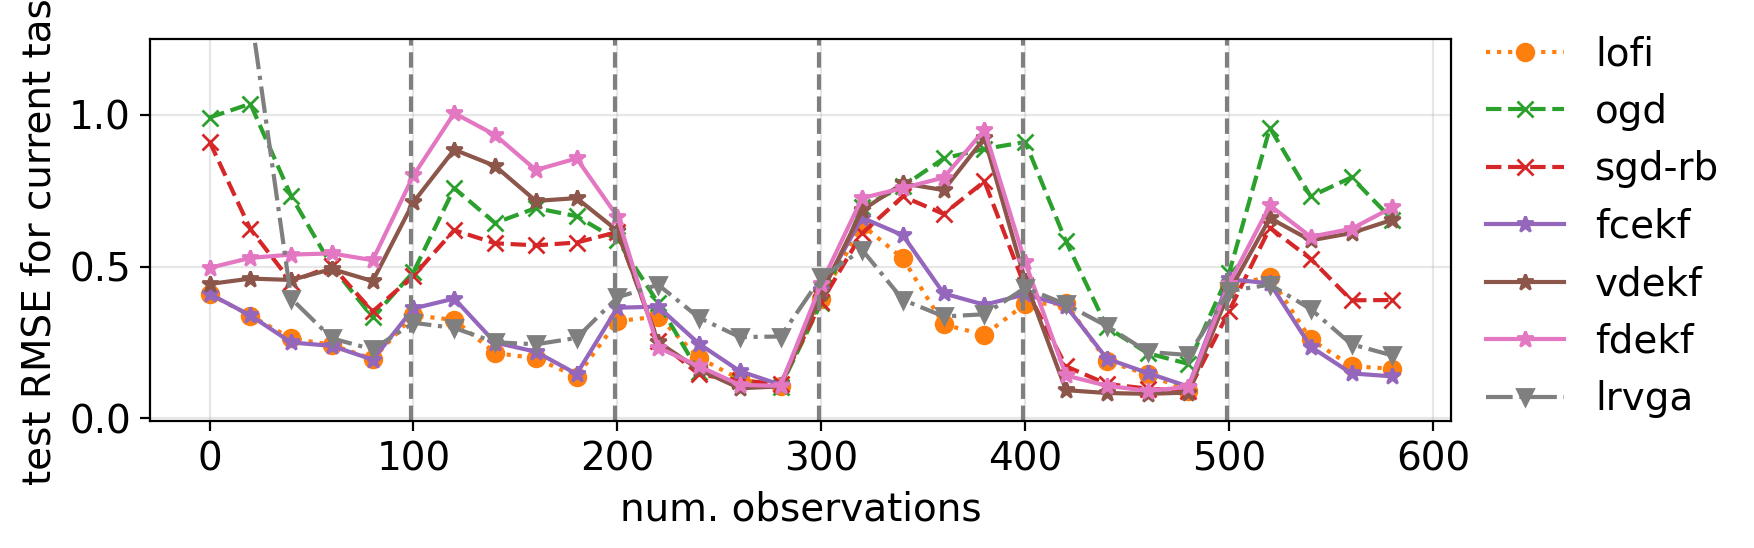

In [1333]:
ntasks, ntrain_per_task, _ = X_train_tasks.shape
changepoints = np.arange(ntrain_per_task, (ntasks)*ntrain_per_task, step=ntrain_per_task)-1
color_dict, style_dict, marker_dict = make_plot_dict(method_list)

plt.figure(figsize=(9, 3))
for i, method in enumerate(method_list):
    ttl = '{:s}, elapsed={:0.2f}'.format(method, elapsed_list[i])
    kernel_size = 20
    
    if "sgd" in method:
        if "B 1 " in method:
            raw_method = "ogd"
        else:
            raw_method = "sgd-rb"
    else:
        raw_method = method.split(" ")[0]
    kernel = jnp.ones(kernel_size) / kernel_size
    rmse_trace = output_list[i]['rmse_test_current_task']
    rmse_smoothed = jnp.convolve(rmse_trace, kernel, mode='same')
    #rmse_smoothed = rmse_trace
    ndata = len(rmse_smoothed)
    ndx = np.arange(0, ndata, step=20) # thin the data so we can see the markers
    plt.plot(ndx, rmse_smoothed[ndx], label=raw_method, color=color_dict[method], linestyle=style_dict[method], marker=marker_dict[method])
    #plt.plot(ndx, rmse_smoothed[ndx], label=ttl, color=color_list[i], linestyle=style_list[i], marker=marker_list[i])
#plt.ylim([0, 1.5])

for c in changepoints:
    plt.axvline(x=c, color="tab:gray", linestyle="--")
# plt.legend(bbox_to_anchor=(0.7, -0.2), frameon=False)
plt.legend(bbox_to_anchor=(1, 1.1), frameon=False)
plt.ylabel('test RMSE for current task')
plt.xlabel('num. observations')
plt.grid(alpha=0.3)
plt.ylim(-0.01, 1.25)
plt.tight_layout()

# plt.savefig(figdir + '/regression_plot_1d_lofi.pdf')
# plt.savefig(figdir + '/regression_plot_1d_lofi.png')

In [1334]:
output_total = {
    method: {
        "seconds": seconds,
        "output": output
    }
    for method, seconds, output in zip(method_list, elapsed_list, output_list)
}

In [1335]:
def plot_pred(Xtr, ytr, Xte, yte, yhat, ttl, ax=None):
    if ax is None:
        fig, ax = plt.subplot()
    
    ixs_tr = np.argsort(Xtr, 0).ravel()
    ixs_te = np.argsort(Xte, 0).ravel()
    
    ax.plot(Xtr[ixs_tr], ytr[ixs_tr], color="black", label='train')
    ax.scatter(Xte[ixs_te], yte[ixs_te], color="tab:red", label='test', alpha=0.8)
    ax.scatter(Xte[ixs_te], yhat[ixs_te], color="tab:blue", label='pred', alpha=0.8)
    ax.set_xticklabels([])
    # ax.legend()

In [1336]:
def plot_pred_task(task, outputs, ax, name='', offset=0):
    times = jnp.where(train_id_seq == task)
    last_time = times[0][-1]
    yhat = outputs['pred_test_current_task'][last_time,:]
    rmse = outputs['rmse_test_current_task'][last_time]
    mae = outputs['mae_test_current_task'][last_time]
    ttl = '{:s}, mae={:0.3f}'.format(name,  mae)
    plot_pred(X_train_tasks[task], Y_train_tasks[task], X_test_tasks[task], Y_test_tasks[task], yhat, ttl, ax)

CPU times: user 5.43 s, sys: 1.15 s, total: 6.58 s
Wall time: 3.75 s


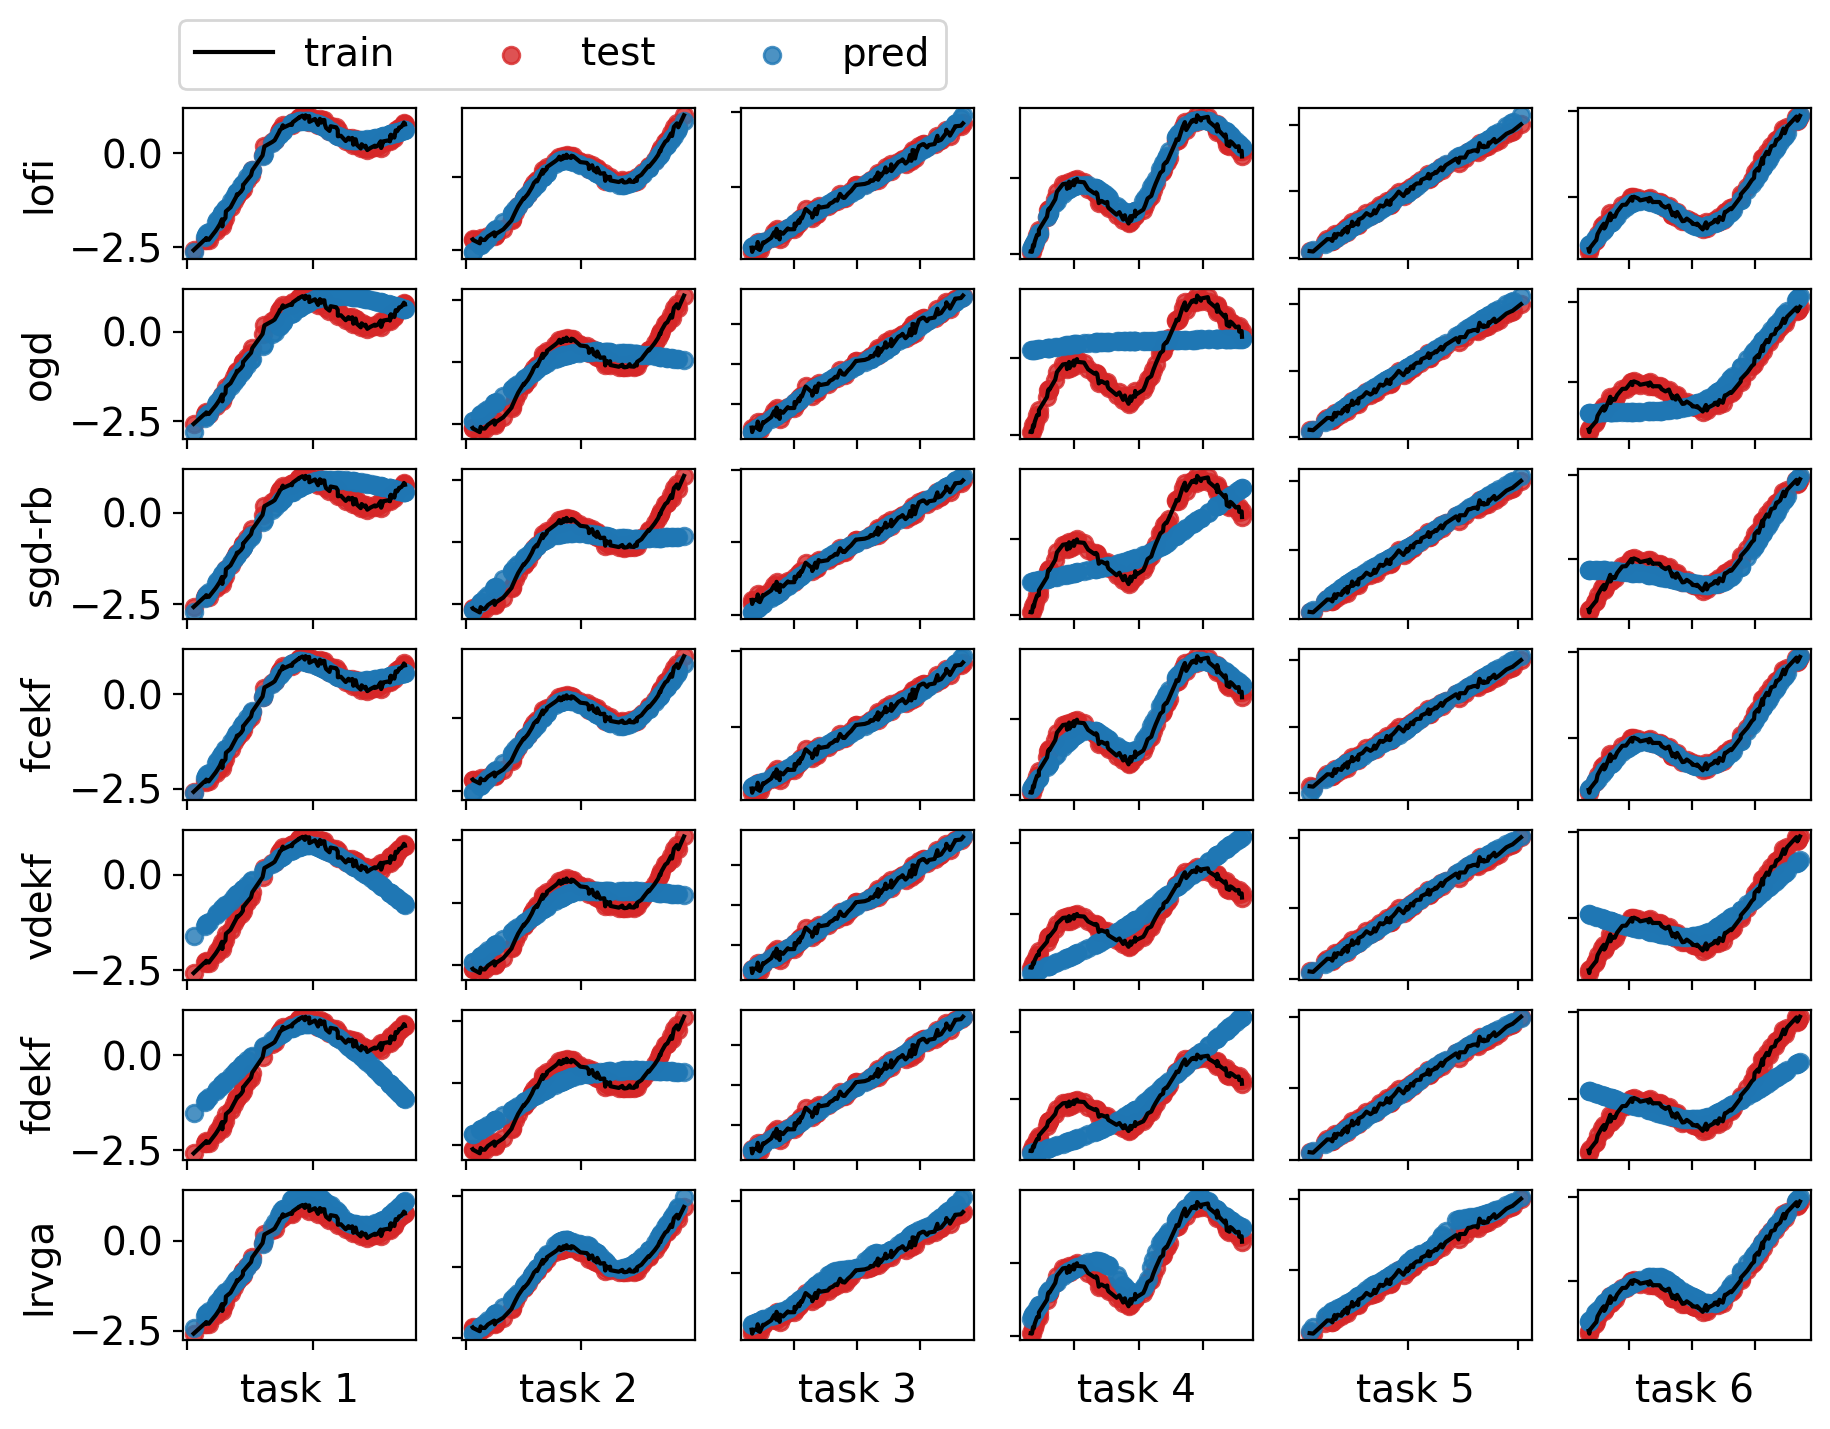

In [1337]:
%%time
fig, axs_grid = plt.subplots(7, 6, figsize=(10.5,  8))

for axs, method in zip(axs_grid, method_list):
    outputs = output_total[method]["output"]
    if "B" in method:
        agent_name = "sgd-rb" if "B 10" in method else "ogd"
    else:
        agent_name = method.split(" ")[0].rstrip(",")
        
    for task, ax in enumerate(axs):
        plot_pred_task(task, outputs, ax, method)
        if task == 0:
            ax.set_ylabel(agent_name)
        else:
            ax.set_yticklabels([])

for t, ax in enumerate(axs):
    ax.set_xlabel(f"task {t+1}")
axs_grid[0, 0].legend(ncol=3, bbox_to_anchor=(-0.1, 1.0), loc="lower left")
# plt.tight_layout()
# plt.savefig(figdir + '/regression_plot_1d_pred.png', dpi=200)

In [1338]:
output_list.pop(-1)
elapsed_list.pop(-1)
method_list.pop(-1)

'lrvga mem 10, alpha 0.995'

# Animation

In [28]:
from matplotlib.animation import FuncAnimation

def reshape_task(x):
    n_obs, *shape = x.shape
    new_shape = (n_dist, -1, *shape)
    return x.reshape(new_shape)

xtest_ravel = jnp.linspace(-2.0, 2.0, num=50)[:, None]

@partial(jax.vmap, in_axes=(0, None, None, None))
@partial(jax.vmap, in_axes=(None, 0, None, None))
def xmap_yhat(task, obs, bel_reshape, apply_fn):
    bel = jax.tree_map(lambda x: x[task, obs, ...], bel_reshape)
    task = train_id_seq[t]
    yhat = apply_fn(bel.mean, xtest_ravel).squeeze()
    
    return yhat

## Comparison posterior mean

In [29]:
agent = "lofi mem 10, q 0.01, alpha 0.01"
bel_reshape_lofi = jax.tree_map(reshape_task, output_total[agent]["output"]["bel"])

agent = "sgd lr 0.100 B 10 E 1"
# agent = "fdekf"
bel_reshape_rbsgd = jax.tree_map(reshape_task, output_total[agent]["output"]["bel"])


agent = "lrvga mem 10, alpha 0.995"
bel_reshape_lrvga = jax.tree_map(reshape_task, output_total[agent]["output"]["bel"])

In [30]:
tasks = jnp.arange(n_dist)
obs = jnp.arange(n_train)

yhat_xmap_lofi = np.array(xmap_yhat(tasks, obs, bel_reshape_lofi, apply_fn_flat))
yhat_xmap_rbsgd = np.array(xmap_yhat(tasks, obs, bel_reshape_rbsgd, apply_fn_unflat))

Y_test_tasks = np.array(Y_test_tasks)
X_test_tasks = np.array(X_test_tasks)

In [31]:
ymin, ymax = Y_train_tasks.min(), Y_train_tasks.max()

CPU times: user 1min 30s, sys: 2.94 s, total: 1min 33s
Wall time: 1min 26s


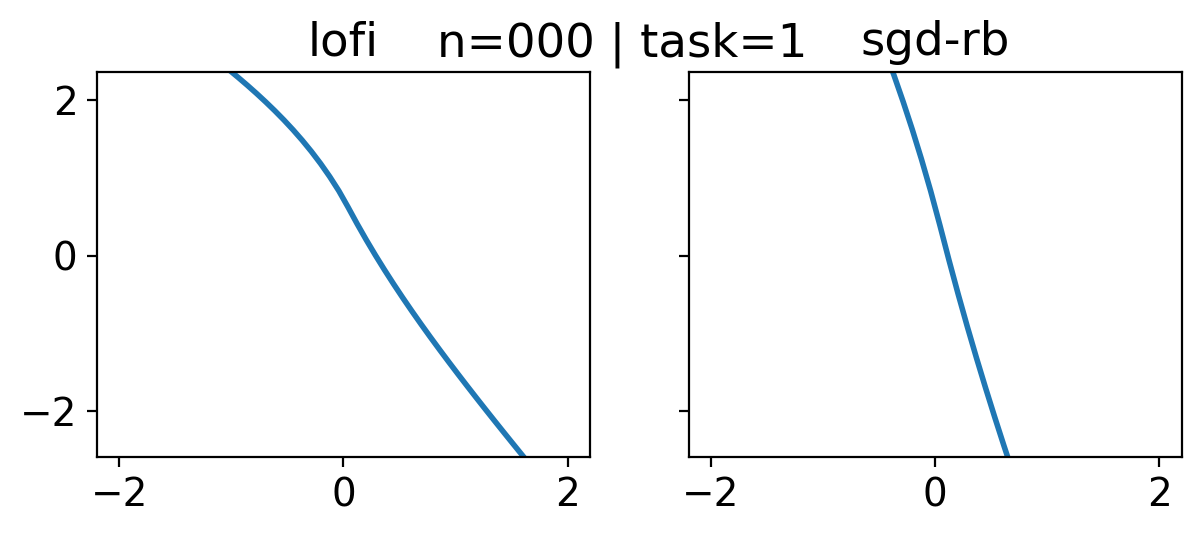

In [33]:
%%time
fig, axs = plt.subplots(1, 2, figsize=(7, 2.5), sharex=True, sharey=True)

labels = ["lofi", "sgd-rb"]
elements = [yhat_xmap_lofi, yhat_xmap_rbsgd]

def update(ix):
    num_obs = ix % n_train
    task = ix // n_train
    
    for ax, label, yhat_xmap in zip(axs, labels, elements):
        ax.cla()
        yhat = yhat_xmap[task, num_obs, ...]

        # nmin = jnp.clip(num_obs - 20, 0)
        nmin = 0

        xtest = X_test_tasks[task][nmin:num_obs]
        ytrue = Y_test_tasks[task].ravel()[nmin:num_obs]

        ax.plot(xtest_ravel, yhat, c="tab:blue", linewidth=2)
        ax.scatter(xtest, ytrue, facecolors="none", edgecolors="tab:gray")
        if len(xtest) > 0:
            ax.scatter(xtest[-1], ytrue[-1], c="tab:red")
        
        ax.set_ylim(ymin, ymax)
        ax.set_title(label)
    plt.suptitle(f"n={num_obs:03} | task={task+1}")
    return axs


frames = np.arange(n_dist * n_train)
ani = FuncAnimation(fig, update, frames=frames)

ani.save("./figures/learned_hist.mp4", dpi=100, bitrate=-1, fps=10)

## Comparison posterior predictive

In [1339]:
estimator_lofi = estimator_list[0]
estimator_lofi.predict_state

<bound method RebayesLoFi.predict_state of <rebayes.low_rank_filter.lofi.RebayesLoFi object at 0x7f267edbc460>>

In [1340]:
estimator_fcekf = estimator_list[3]
estimator_fcekf.method

'fcekf'

In [1341]:
@partial(jax.vmap, in_axes=(0, None, None, None, None))
@partial(jax.vmap, in_axes=(None, 0, None, None, None))
def xmap_yhat_sample(task, obs, bel_reshape, apply_fn, n_samples):
    bel = jax.tree_map(lambda x: x[task, obs, ...], bel_reshape)
    task = train_id_seq[t]
    
    # bel = estimator_lofi.predict_state(bel)
    # bel = estimator_fcekf.predict_state(bel)
    
    mean = bel.mean
    
    # prec = bel.Ups.ravel() * jnp.eye(len(mean)) + bel.basis @ bel.basis.T 
    # cov = jnp.linalg.inv(prec)
    cov = bel.cov
    
    params_sample = jax.random.multivariate_normal(key, mean, cov, (n_samples,))
    yhat = jax.vmap(apply_fn, (0, None))(params_sample, xtest_ravel).squeeze()
    # yhat = apply_fn(bel.mean, xtest_ravel).squeeze()[None, ...]
    
    return yhat

In [1342]:
agent = "lofi mem 10, q 0.01, alpha 0.01"
bel_reshape_lofi = jax.tree_map(reshape_task, output_total[agent]["output"]["bel"])

agent = "fdekf"
bel_reshape_fdekf = jax.tree_map(reshape_task, output_total[agent]["output"]["bel"])

agent = "fcekf"
bel_reshape_fcekf = jax.tree_map(reshape_task, output_total[agent]["output"]["bel"])

agent = "lrvga mem 10, alpha 0.995"
bel_reshape_lrvga = jax.tree_map(reshape_task, output_total[agent]["output"]["bel"])

In [1343]:
jax.tree_map(jnp.shape, bel_reshape_fcekf)

EKFBel(mean=(6, 100, 151), cov=(6, 100, 151, 151), nobs=(6, 100), obs_noise_var=(6, 100))

In [1344]:
%%time
n_samples = 55
# zyhat_xmap_lofi = np.array(xmap_yhat_sample(tasks, obs, bel_reshape_lofi, apply_fn_flat, n_samples))

# yhat_xmap_fcekf = np.array(xmap_yhat_sample(tasks, obs, bel_reshape_fcekf, apply_fn_flat, n_samples))

# yhat_xmap_fdekf = np.array(xmap_yhat_sample(tasks, obs, bel_reshape_fdekf, apply_fn_flat, n_samples))

yhat_xmap_lrvga = np.array(xmap_yhat_sample(tasks, obs, bel_reshape_lrvga, apply_fn_flat, n_samples))

CPU times: user 121 ms, sys: 14.1 ms, total: 135 ms
Wall time: 234 ms


In [1360]:
num_obs = 99
task = 3

In [1361]:
method = "lrvga"
xtest = X_test_tasks[task][:num_obs]
yhat_samples = yhat_xmap_lrvga[task, num_obs, ...]
yhat_mean = yhat_samples.mean(axis=0)

Text(0.5, 1.0, 'lrvga')

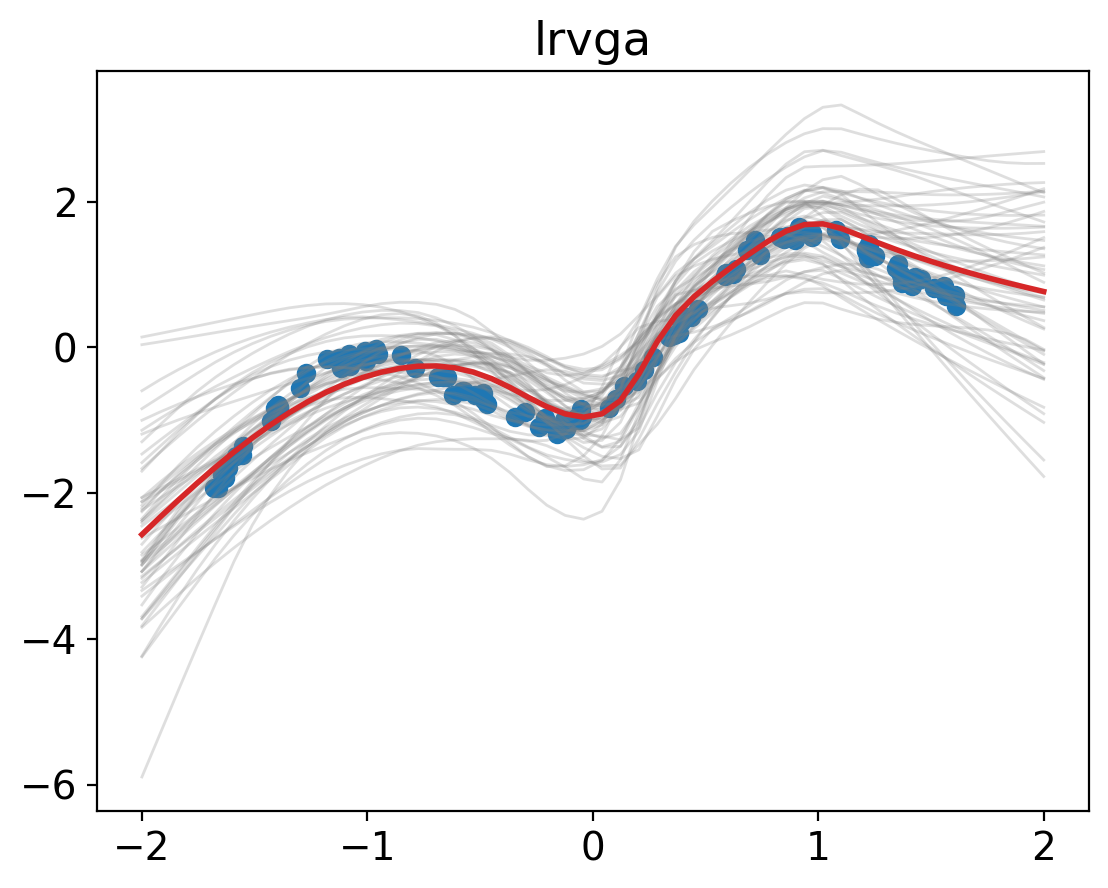

In [1362]:
for yhat in yhat_samples:
    plt.plot(xtest_ravel, yhat, c="tab:gray", linewidth=1, alpha=0.25)
plt.plot(xtest_ravel, yhat_mean, c="tab:red", linewidth=2)
plt.scatter(X_train_tasks[task], Y_train_tasks[task])
plt.title(method)
# plt.ylim(-3, 3)

In [1185]:
jax.tree_map(jnp.shape, bel_reshape_lrvga)

LRVGAState(key=(6, 100, 2), mu=(6, 100, 151), W=(6, 100, 151, 10), Psi=(6, 100, 151), sigma=(6, 100), step=(6, 100))

In [1186]:
diag_xmap = jax.vmap(jax.vmap(jnp.diag, 1), 0)(bel_reshape_fcekf.cov)
jax.tree_map(jnp.shape, diag_xmap)

(6, 151, 100)

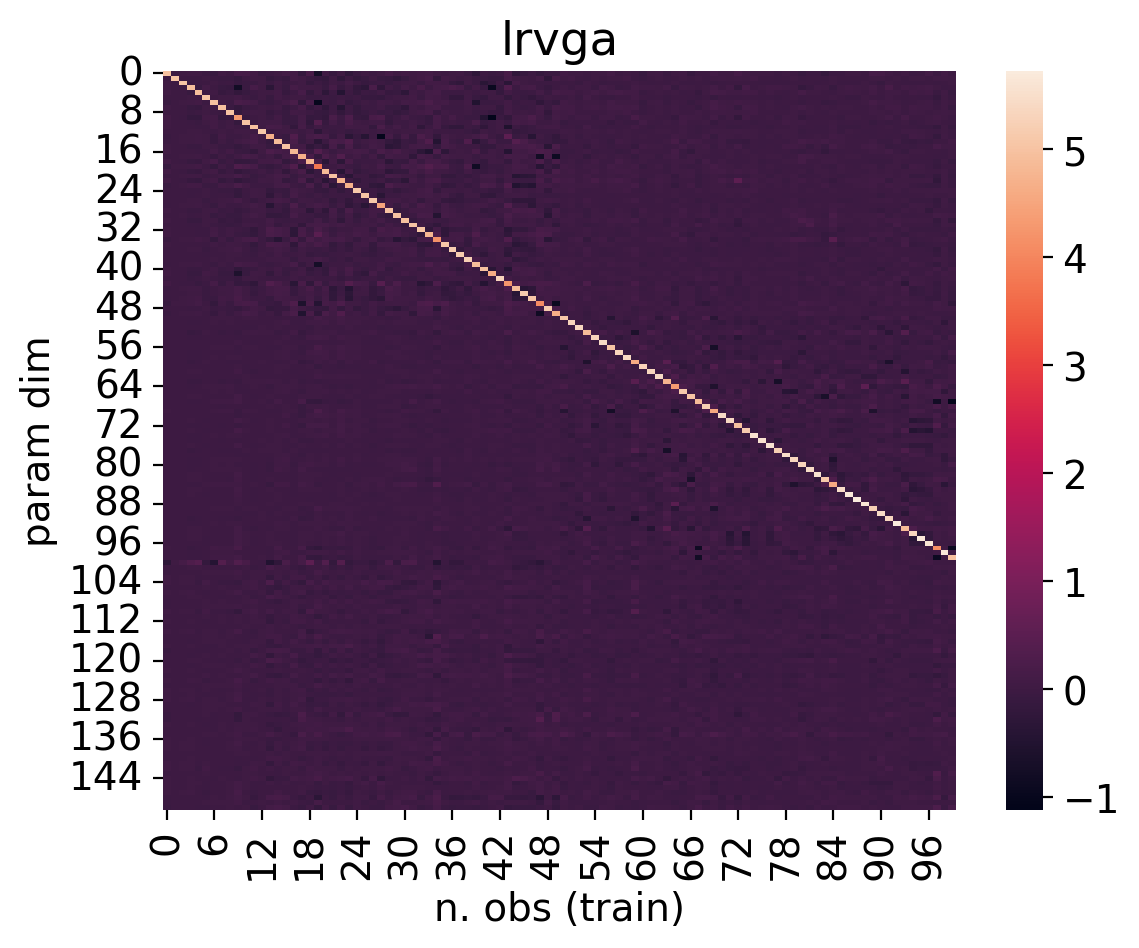

In [972]:
sns.heatmap(diag_xmap[0])
plt.title(method)
plt.ylabel("param dim")
plt.xlabel("n. obs (train)");

In [731]:
xsel = np.arange(100)
diag_xmap[0, xsel, xsel]

Array([0.10942569, 0.12022434, 0.13025525, 0.13990864, 0.14959125,
       0.16064338, 0.16881052, 0.17929047, 0.19096234, 0.19021763,
       0.21001425, 0.22119598, 0.23204045, 0.23993158, 0.25109923,
       0.26116198, 0.2714952 , 0.28189093, 0.28401014, 0.2957153 ,
       0.30687708, 0.32311785, 0.32337204, 0.33967948, 0.35502344,
       0.36537573, 0.37550056, 0.38426125, 0.3934047 , 0.40739447,
       0.4087943 , 0.4250466 , 0.4379711 , 0.44810256, 0.4543593 ,
       0.4698148 , 0.4793936 , 0.49068832, 0.50182927, 0.5102354 ,
       0.5164008 , 0.51318914, 0.5404292 , 0.5476767 , 0.5600576 ,
       0.57176113, 0.57773226, 0.58455575, 0.60505056, 0.6118138 ,
       0.62765706, 0.63845426, 0.6492045 , 0.65242785, 0.66599196,
       0.68126905, 0.6902575 , 0.6980561 , 0.71249616, 0.71195614,
       0.7339366 , 0.74573267, 0.7568391 , 0.76553535, 0.7782829 ,
       0.7874691 , 0.7997489 , 0.8046146 , 0.8154999 , 0.826675  ,
       0.83816683, 0.85265803, 0.85495365, 0.87244946, 0.88529